# Data preparation

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

Image preprocessing: *variant 3*

1. Alignement between panchromatic and SWIR

2. Upsample SWIR

3. Pansharpen MS

In [2]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import cv2 

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
import os
import sys
sys.path.append("../common/")

from data_utils import TRAIN_LABEL_TILES, TRAIN_DATA, TRAIN_IMAGE_IDS, LABELS, ALL_IMAGE_IDS
from data_utils import get_resized_polygons, get_filename, get_tile_filename
from image_utils import generate_pansharpened, generated_upsampled_swir, imwrite 
from image_utils import get_image_data, generate_label_file, generate_aligned_swir, spot_cleaning
from otb_preprocessing import generate_rm_indices
from visu_utils import display_img_1b
from preprocessing_utils import create_pan_rad_inds_ms, create_pan_ms_swir, create_ms

Generate images : MS pansharpened

In [4]:
def generate_MS(image_ids):
    sc_threshold = 0.1    
    for i, image_id in enumerate(image_ids):
        print "--", image_id, i+1, "/", len(image_ids)
        x = create_ms(image_id, sc_threshold=sc_threshold)
        imwrite(get_filename(image_id, 'ms_pan'), x)

In [ ]:
generate_MS(TRAIN_IMAGE_IDS)

In [6]:
generate_MS(["6120_2_4"])

-- 6120_2_4 1 / 1


Generate images : 17 bands images

In [7]:
def generate_17b(image_ids, do_generate_17b_images, do_generate_labels):

    sc_threshold = 0.1
    
    for i, image_id in enumerate(image_ids):
        print "--", image_id, i+1, "/", len(image_ids)

        if do_generate_labels:
            # Generate label image
            generate_label_file(image_id, multi_dim=False)        
        
        if do_generate_17b_images:
            x = create_pan_rad_inds_ms(image_id, sc_threshold=sc_threshold)
            imwrite(get_filename(image_id, 'input'), x)                

Generate preprocessed training images

In [8]:
image_ids = TRAIN_IMAGE_IDS
generate_17b(image_ids, False, True)

-- 6040_2_2 1 / 25
-- 6120_2_2 2 / 25
-- 6120_2_0 3 / 25
-- 6090_2_0 4 / 25
-- 6040_1_3 5 / 25
-- 6040_1_0 6 / 25
-- 6100_1_3 7 / 25
-- 6010_4_2 8 / 25
-- 6110_4_0 9 / 25
-- 6140_3_1 10 / 25
-- 6110_1_2 11 / 25
-- 6100_2_3 12 / 25
-- 6150_2_3 13 / 25
-- 6160_2_1 14 / 25
-- 6140_1_2 15 / 25
-- 6110_3_1 16 / 25
-- 6010_4_4 17 / 25
-- 6170_2_4 18 / 25
-- 6170_4_1 19 / 25
-- 6170_0_4 20 / 25
-- 6060_2_3 21 / 25
-- 6070_2_3 22 / 25
-- 6010_1_2 23 / 25
-- 6040_4_4 24 / 25
-- 6100_2_2 25 / 25


Generate a custom preprocessed image

In [9]:
ALL_IMAGE_IDS[:10]

array(['6120_2_4', '6120_2_3', '6120_2_2', '6120_2_1', '6120_2_0',
       '6180_2_4', '6180_2_1', '6180_2_0', '6180_2_3', '6180_2_2'], dtype=object)

In [7]:
generate_17b(['6080_4_0'], True, False)

-- 6080_4_0 1 / 

ERROR:root:Failed to find warp matrix: C:\projects\opencv-python\opencv\modules\video\src\ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function cv::findTransformECC



1


In [ ]:
# take some pictures from test 
waterway_test = ['6080_4_3','6080_4_0',
                 '6080_1_3', '6080_1_1',
                 '6150_3_4', '6050_2_1']

In [8]:
generate_17b(waterway_test[2:], True, False)

-- 

ERROR:root:Failed to find warp matrix: C:\projects\opencv-python\opencv\modules\video\src\ecc.cpp:515: error: (-7) NaN encountered. in function cv::findTransformECC

ERROR:root:Failed to find warp matrix: C:\projects\opencv-python\opencv\modules\video\src\ecc.cpp:515: error: (-7) NaN encountered. in function cv::findTransformECC

ERROR:root:Failed to find warp matrix: C:\projects\opencv-python\opencv\modules\video\src\ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function cv::findTransformECC

ERROR:root:Failed to find warp matrix: C:\projects\opencv-python\opencv\modules\video\src\ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function cv::findTransformECC

ERROR:root:Failed to find warp matrix: C:\projects\opencv-python\opencv\modules\video\src\ecc.cpp:530: e

6080_1_3 1 / 4
--

ERROR:root:Failed to find warp matrix: C:\projects\opencv-python\opencv\modules\video\src\ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function cv::findTransformECC

ERROR:root:Failed to find warp matrix: C:\projects\opencv-python\opencv\modules\video\src\ecc.cpp:515: error: (-7) NaN encountered. in function cv::findTransformECC



 6080_1_1 2 / 4
-- 6150_3_4 3 / 4
-- 6050_2_1 4 / 4


In [32]:
#get_image_data('6040_2_2', 'input', return_shape_only=True)

(3348, 3391, 17)

Create mean / std tile for a dataset

In [45]:
import os
import logging
from glob import glob
all_train_files = glob(os.path.join(TRAIN_DATA, "*.tif"))
all_train_files = np.array([s[len(TRAIN_DATA)+1:-4] for s in all_train_files if 'mean' not in s and 'std' not in s])
print "First train tile : ", all_train_files[0], all_train_files[-1], len(all_train_files)

First train tile :  6010_1_2 6170_4_1 25


In [46]:
from image_utils import imwrite, compute_mean_std_on_images
from geo_utils.GeoImage import GeoImage

ll = int(len(all_train_files)*0.8)
train_files = all_train_files[:ll]
val_files = all_train_files[ll:]


mean_fname = os.path.join(TRAIN_DATA, 'mean_image.tif')
std_fname = os.path.join(TRAIN_DATA, 'std_image.tif')
if not os.path.exists(mean_fname) or not os.path.exists(std_fname):
    logging.getLogger().setLevel(logging.INFO)
    mean_image, std_image = compute_mean_std_on_images(train_files, 'input')
    logging.getLogger().setLevel(logging.ERROR)
    imwrite(mean_fname, mean_image)
    imwrite(std_fname, std_image)
else:
    mean_image = GeoImage(mean_fname).get_data()
    std_image = GeoImage(mean_fname).get_data()

print mean_image.shape, std_image.shape
print mean_image.min(), mean_image.max(), std_image.min(), std_image.max()
print len(train_files), len(val_files)

logging.getLogger().setLevel(logging.ERROR)

In [47]:
print mean_image.dtype, mean_image.min(), mean_image[:,:,0].mean(), mean_image.max(), mean_image.shape
print std_image.dtype, std_image.min(), std_image.max(), std_image.shape

float32 -17271.4 501.715 1526.71 (3349L, 3404L, 13L)
float32 0.0 84919.8 (3349L, 3404L, 13L)


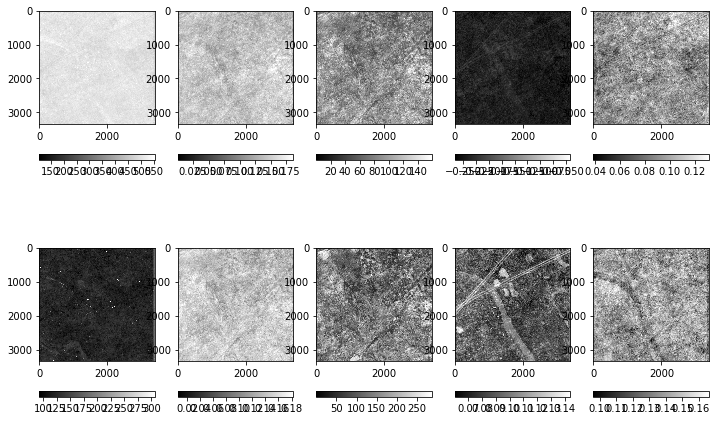

In [58]:
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(2,5,i+1)
    display_img_1b(mean_image[:,:,i])

for i in range(5):
    plt.subplot(2,5,5+i+1)
    display_img_1b(std_image[:,:,i])

In [117]:
def inversion(tile):
    inv_tile = tile + tile.min() + 100
    eps = 1e-7
    inv_tile = np.power(inv_tile+eps, -1.0)
    mean = np.mean(inv_tile)
    std = np.std(inv_tile)
    inv_tile = (inv_tile - mean)/std
    return inv_tile

In [84]:
count = 0

-- 0 6010_4_4_3072_1728.tif -0.232726256788 0.176870446737 (256L, 256L, 17L)
-- 1 6010_4_4_3072_2176.tif -0.246076510752 0.143217154541 (256L, 256L, 17L)
-- 2 6010_4_4_3072_2624.tif -0.241625480505 0.290977790965 (256L, 256L, 17L)
-- 3 6010_4_4_3072_3072.tif -0.20921606634 0.253230111867 (256L, 256L, 17L)
-- 4 6010_4_4_3072_384.tif -0.238901890141 0.204530204508 (256L, 256L, 17L)


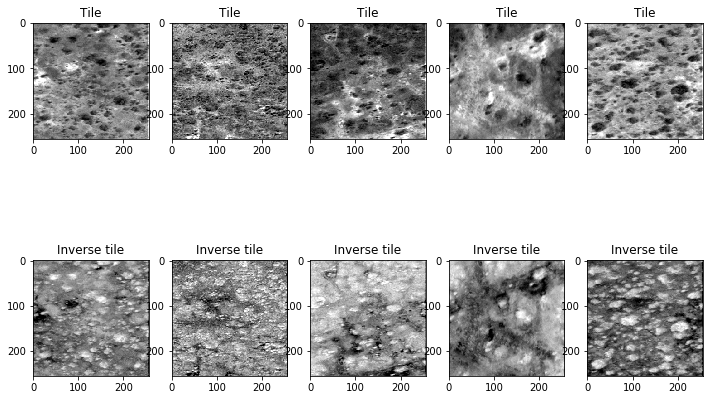

In [125]:
plt.figure(figsize=(12,8))
for i, tile_id in enumerate(trainset_ids[count:count+5]):
    
    tile = get_image_tile_data(os.path.join(TRAIN_DATA,tile_id)).astype(np.float)
    tile -= mean_tile_image
    tile /= std_tile_image
    
    inv_tile = inversion(tile)   
    
    print "--", i, tile_id, tile.min(), tile.max(), tile.shape
    plt.subplot(2,5,i + 1)
    display_img_1b(tile[:,:,i])
    plt.title("Tile")
    
    plt.subplot(2,5,5 + i + 1)
    display_img_1b(inv_tile[:,:,i])
    plt.title("Inverse tile")

    
count += 5

In [41]:
615  **2

378225

In [38]:
# from data_utils import generate_label_image2
# img_label = generate_label_image2('6120_2_0')
# print img_label.shape, img_label.dtype,  img_label.min(), img_label.max()

In [12]:
gimg_label = GeoImage(get_filename('6010_1_2', 'label'))
img_label = gimg_label.get_data()
print img_label.shape, img_label.dtype, img_label.min(), img_label.max()

(3348L, 3396L, 11L) uint8 0 1


In [13]:
gimg_label = GeoImage(get_filename('6110_3_1', 'label'))
img_label = gimg_label.get_data()
print img_label.shape, img_label.dtype, img_label.min(), img_label.max()

(3348L, 3396L, 11L) uint8 0 1


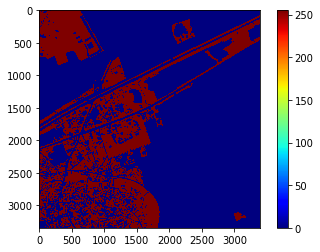

In [142]:
plt.figure()
display_img_1b(img_label[:,:,0], cmap=plt.get_cmap('jet'))
plt.colorbar()

In [143]:
gimg_test = GeoImage(TRAIN_DATA + '/6120_2_0_1280_1728.tif')
img = gimg_test.get_data()
print img.shape, img.dtype, img.min(), img.max()

gimg_test_label = GeoImage(TRAIN_LABEL_TILES + '/6120_2_0_1280_1728.tif')
img_label = gimg_test_label.get_data()
print img_label.shape, img_label.dtype, img_label.min(), img_label.max()


(256L, 256L, 17L) uint16 311 1148
(256L, 256L, 11L) uint8 0 199


ERROR! Session/line number was not unique in database. History logging moved to new session 476


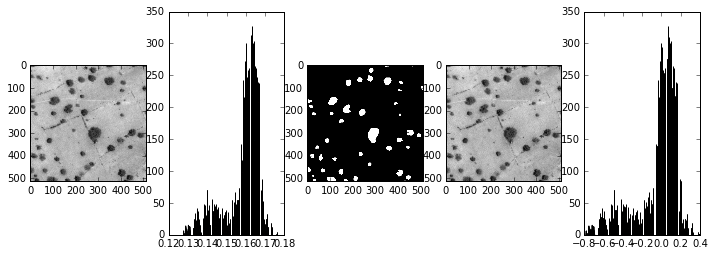

In [17]:
nimg = img * 1.0/2**12
nnimg = (img - np.mean(img))/np.std(img)
plt.figure(figsize=(12,4))
plt.subplot(151)
plt.imshow(nimg[:,:,0], cmap='gray')
plt.subplot(152)
plt.hist(nimg[:,:,0])
plt.subplot(153)
plt.imshow(img_label[:,:,5], cmap='gray')
plt.subplot(154)
plt.imshow(nnimg[:,:,0], cmap='gray')
plt.subplot(155)
_ = plt.hist(nnimg[:,:,0])

In [132]:
gimg_test = GeoImage(TRAIN_DATA + '/6110_3_1_1280_1728.tif')
gimg_test = GeoImage(TRAIN_DATA + '/6110_3_1_1280_1728.tif')

img = gimg_test.get_data()
print img.shape, img.dtype, img.min(), img.max()

gimg_test_label = GeoImage(TRAIN_LABEL_TILES + '/6110_3_1_1280_1728.tif')
img_label = gimg_test_label.get_data()
print img_label.shape, img_label.dtype, img_label.min(), img_label.max() 


(256L, 256L, 17L) uint16 197 2304
(256L, 256L, 11L) uint8 0 255


In [136]:
for i in range(img_label.shape[2]):
    print i, img_label[:,:,i].min(), img_label[:,:,i].max()

0 0 1
1 0 1
2 0 1
3 0 0
4 0 0
5 0 1
6 0 1
7 0 0
8 0 255
9 0 253
10 0 254


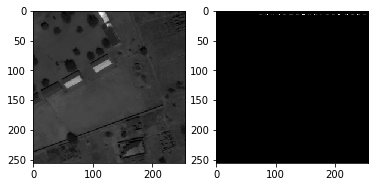

In [138]:
nimg = img * 1.0/2**12
plt.figure()
plt.subplot(121)
plt.imshow(nimg[:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(img_label[:,:,10], cmap='gray')

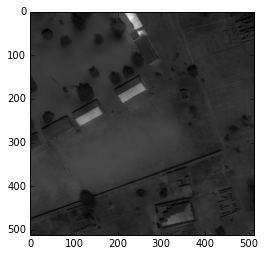

In [46]:
from image_utils import get_image_tile_data

img = get_image_tile_data(TRAIN_DATA + '/6110_3_1_1280_1728.tif')

nimg = img * 1.0/2**12
plt.figure()
plt.imshow(nimg[:,:,16], cmap='gray')

In [47]:
from image_utils import get_image_data
label_img = get_image_data("6100_2_2", 'label')
label_img.shape

(3348, 3391, 11)

In [9]:

def normalize_image(img_data, interp=cv2.INTER_CUBIC):
    img_data = cv2.resize(img_data, dsize=(512, 512), interpolation=interp)
    out = np.zeros_like(img_data)
    for c in range(img_data.shape[2]):        
        min_value, max_value, _, _ = cv2.minMaxLoc(img_data[:,:,c])
        out[:,:,c] = (img_data[:,:,c] - min_value)/(max_value - min_value + 0.0001)            
    out = out.transpose([2,0,1])
    out = out[None,:]
    return out

In [19]:
gimg_test = GeoImage(TRAIN_DATA + '/6120_2_0_1280_1728.tif')
img = gimg_test.get_data()
print img.shape, img.dtype, img.min(), img.max()

(512, 512, 17) uint16 308 1153


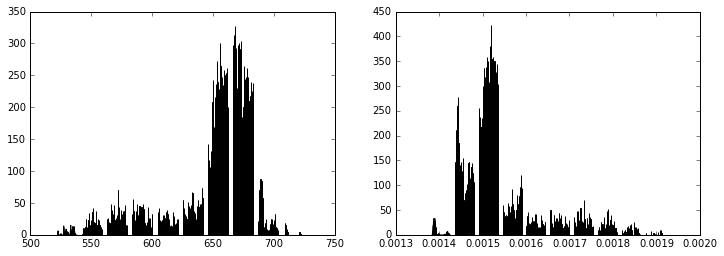

In [20]:
inv_img = 1.0/img

plt.figure(figsize=(12,4))
plt.subplot(121)
_ = plt.hist(img[:,:,0])
plt.subplot(122)
_ = plt.hist(inv_img[:,:,0])

Generate 1-band labels

In [5]:
for i, image_id in enumerate(TRAIN_IMAGE_IDS):
    print "--", image_id, i, "/", len(TRAIN_IMAGE_IDS)
    
    # Generate label image
    generate_label_file(image_id, multi_dim=False)

-- 6040_2_2 0 / 25
-- 6120_2_2 1 / 25
-- 6120_2_0 2 / 25
-- 6090_2_0 3 / 25
-- 6040_1_3 4 / 25
-- 6040_1_0 5 / 25
-- 6100_1_3 6 / 25
-- 6010_4_2 7 / 25
-- 6110_4_0 8 / 25
-- 6140_3_1 9 / 25
-- 6110_1_2 10 / 25
-- 6100_2_3 11 / 25
-- 6150_2_3 12 / 25
-- 6160_2_1 13 / 25
-- 6140_1_2 14 / 25
-- 6110_3_1 15 / 25
-- 6010_4_4 16 / 25
-- 6170_2_4 17 / 25
-- 6170_4_1 18 / 25
-- 6170_0_4 19 / 25
-- 6060_2_3 20 / 25
-- 6070_2_3 21 / 25
-- 6010_1_2 22 / 25
-- 6040_4_4 23 / 25
-- 6100_2_2 24 / 25


Generate 1-band labels and 17 bands image tiles

In [18]:
# tile_size = (512, 512)
# overlapping = 64
# include_nodata = True

# for i, image_id in enumerate(TRAIN_IMAGE_IDS):
#     print "--", image_id, i, "/", len(TRAIN_IMAGE_IDS)
    
#     # Generate aligned swir file
#     generate_aligned_swir(image_id)    
    
#     # Generate pansharpened
#     generate_pansharpened(image_id, 'ms')
#     generate_pansharpened(image_id, 'swir_aligned')
#     # Generate label image
#     generate_label_file(image_id, multi_dim=False)

#     gimg_pan = GeoImage(get_filename(image_id, 'pan'))
#     gimg_ms = GeoImage(get_filename(image_id, 'ms_pan'))
#     gimg_swir = GeoImage(get_filename(image_id, 'swir_pan'))
#     gimg_label = GeoImage(get_filename(image_id, 'label_1d'))
    
#     gimg_pan_tiles = GeoImageTiler(gimg_pan, tile_size=tile_size, overlapping=overlapping, include_nodata=include_nodata, nodata_value=0.0)
#     gimg_ms_tiles = GeoImageTiler(gimg_ms, tile_size=tile_size, overlapping=overlapping, include_nodata=include_nodata, nodata_value=0.0)
#     gimg_swir_tiles = GeoImageTiler(gimg_swir, tile_size=tile_size, overlapping=overlapping, include_nodata=include_nodata, nodata_value=0.0)
#     gimg_label_tiles = GeoImageTiler(gimg_label, tile_size=tile_size, overlapping=overlapping, include_nodata=include_nodata, nodata_value=0.0)
    
#     for tile_info_pan, tile_info_ms, tile_info_swir, tile_info_label in \
#             zip(gimg_pan_tiles, gimg_ms_tiles, gimg_swir_tiles, gimg_label_tiles):
    
#         tile_pan, xoffset_pan, yoffset_pan = tile_info_pan
#         tile_ms, xoffset_ms, yoffset_ms = tile_info_ms
#         tile_swir, xoffset_swir, yoffset_swir = tile_info_swir
#         tile_label, xoffset_label, yoffset_label = tile_info_label

#         h, w, _ = tile_pan.shape
#         x = np.zeros((h, w, 17), dtype=np.uint16)
#         x[:,:,0] = tile_pan[:,:,0]; x[:,:,1:9] = tile_ms; x[:,:,9:] = tile_swir
#         imwrite(get_tile_filename(image_id, xoffset_ms, yoffset_ms, '17b'), x)
#         y = tile_label
#         imwrite(get_tile_filename(image_id, xoffset_label, yoffset_label, 'label_1d'), y)    